Learned kernel (original GPR): 0.909**2 * RBF(length_scale=1.75) + WhiteKernel(noise_level=0.00674)
Learned kernel (residual GPR): 0.0615**2 * RBF(length_scale=0.368) + WhiteKernel(noise_level=0.00782)


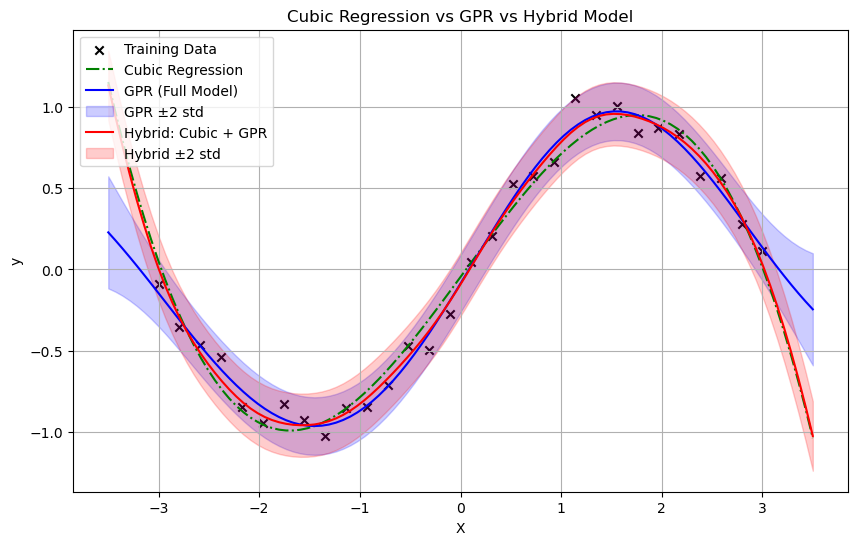

In [15]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# Set random seed
np.random.seed(42)

# Generate training data
X = np.linspace(-3, 3, 30).reshape(-1, 1)
y = np.sin(X).ravel() + np.random.normal(0, 0.1, X.shape[0])

# Generate test data
X_test = np.linspace(-3.5, 3.5, 100).reshape(-1, 1)

# Fit cubic polynomial regression (Degree = 3)
poly_model_cubic = make_pipeline(PolynomialFeatures(3), LinearRegression())
poly_model_cubic.fit(X, y)
y_cubic_pred = poly_model_cubic.predict(X_test)

# Fit GPR with RBF + WhiteKernel functions
kernel = 1.0 * RBF(length_scale=1.0) + WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-6, 1e-1)) # noise level here is variance
gp_model = GaussianProcessRegressor(kernel=kernel)
gp_model.fit(X, y)

# Make predictions using GPR
y_gp_pred, y_gp_std = gp_model.predict(X_test, return_std=True)

# Build hybrid model: Cubic + GPR on residuals
# Compute residuals from the cubic regression
y_cubic_train_pred = poly_model_cubic.predict(X)
residuals = y - y_cubic_train_pred

# Fit GPR on the residuals
gp_on_residuals = GaussianProcessRegressor(kernel=kernel)
gp_on_residuals.fit(X, residuals)

# Predict residuals and combine with cubic predictions
residual_pred, residual_std = gp_on_residuals.predict(X_test, return_std=True)
y_grey_pred = y_cubic_pred + residual_pred
y_grey_std = residual_std

# Visualization
plt.figure(figsize=(10, 6))

# Training data
plt.scatter(X, y, color='black', label="Training Data", marker='x')

# Cubic regression
plt.plot(X_test, y_cubic_pred, label="Cubic Regression", color="green", linestyle="dashdot")

# Original GPR
plt.plot(X_test, y_gp_pred, label="GPR (Full Model)", color="blue")
plt.fill_between(X_test.ravel(), y_gp_pred - 2*y_gp_std, y_gp_pred + 2*y_gp_std, 
                 color="blue", alpha=0.2, label="GPR ±2 std")

# Hybrid model
plt.plot(X_test, y_grey_pred, label="Hybrid: Cubic + GPR", color="red")
plt.fill_between(X_test.ravel(), y_grey_pred - 2*y_grey_std, y_grey_pred + 2*y_grey_std,
                 color="red", alpha=0.2, label="Hybrid ±2 std")

# Labels and title
plt.xlabel("X")
plt.ylabel("y")
plt.title("Cubic Regression vs GPR vs Hybrid Model")
plt.legend()
plt.grid(True)

# Check kernels
print("Learned kernel (original GPR):", gp_model.kernel_)
print("Learned kernel (residual GPR):", gp_on_residuals.kernel_)

# Export and save the finalized plot
import os
os.makedirs("figures from notebook", exist_ok=True)  
plt.savefig("figures from notebook/grey_model_toy.pdf", bbox_inches='tight', dpi=300)
plt.show()